Read CSV data with Pandas.

In [1]:
import pandas as pd
import numpy as np

# team stats
team_summaries = pd.read_csv('nba_data/stats_archive/Team Summaries.csv')
# team_totals = pd.read_csv('nba_data/stats_archive/Team Totals.csv')
team_per100 = pd.read_csv('nba_data/stats_archive/Team Stats Per 100 Poss.csv')

# player stats
# player_totals = pd.read_csv('nba_data/stats_archive/Player Totals.csv')
player_shooting = pd.read_csv('nba_data/stats_archive/Player Shooting.csv')
player_play_by_play = pd.read_csv('nba_data/stats_archive/Player Play By Play.csv')
player_per100 = pd.read_csv('nba_data/stats_archive/Per 100 Poss.csv')

# games
games = pd.read_csv('nba_data/game_archive/games.csv')
teamids = pd.read_csv('nba_data/game_archive/teams.csv')


Remove unnecessary features.

In [2]:
# games
teamids['TEAM_NAME'] = teamids['CITY'] + ' ' + teamids['NICKNAME']
teamids = teamids[['TEAM_ID','TEAM_NAME','ABBREVIATION']]

games = games[['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','HOME_TEAM_WINS','PTS_home','PTS_away']]

In [3]:
# team stats
team_stats = team_summaries.merge(team_per100)
team_stats.drop(columns=['playoffs','arena','attend','lg'], inplace=True)

# player stats
player_stats = player_shooting.merge(player_play_by_play).merge(player_per100)
player_stats.drop(columns=['birth_year','pos','lg'], inplace=True)

Create player efficiency indices.

𝐼NBA=𝑁pts+𝑁rbs+𝑁asts+𝑁stls+𝑁blcks−(𝑁msFld+𝑁msFT+𝑁tos)

In [4]:
player_stats['player_eff_ind'] = (player_stats['pts_per_100_poss'] +
                           player_stats['trb_per_100_poss'] +
                           player_stats['ast_per_100_poss'] +
                           player_stats['stl_per_100_poss'] +
                           player_stats['blk_per_100_poss'] -
                           (player_stats['tov_per_100_poss'] +
                            player_stats['fga_per_100_poss'] - player_stats['fg_per_100_poss'] +
                            player_stats['fta_per_100_poss'] - player_stats['ft_per_100_poss']))
# player_stats

Create team efficiency indices.

In [5]:
#create the team efficeny index by summing the players by season and team 
team_eff_ind = player_stats.groupby(['tm', 'season'])['player_eff_ind'].sum().reset_index(name='team_eff_ind')
team_eff_ind.rename(columns = {'tm':'abbreviation'}, inplace = True)

In [6]:
#merging the team efficeny index to team_stats
team_stats = team_stats.merge(team_eff_ind)
# team_stats

In [7]:
team_stats['next_season'] = team_stats['season'] + 1

To each game, append home and away team stats in the respective season.

In [8]:
# add team_id to team stats
teamids.rename(columns = {'ABBREVIATION':'abbreviation','TEAM_NAME':'team'}, inplace = True)
team_stats = team_stats.merge(teamids)
team_stats.drop(columns=['team','abbreviation'], inplace = True)

In [9]:
min(team_stats.season)

1997

In [10]:
# # add home team stats to games
# h_team_stats = team_stats.add_prefix('h_')
# final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_season'])
# final_df.drop(columns=['h_season','h_TEAM_ID'], inplace = True)

# # add away team stats to games
# a_team_stats = team_stats.add_prefix('a_')
# final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_season'])
# final_df.drop(columns=['a_season','a_TEAM_ID'], inplace = True)

# add home team stats to games
h_team_stats = team_stats.add_prefix('h_')
final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_next_season'])
final_df.drop(columns=['h_season','h_next_season','h_TEAM_ID'], inplace = True)

# add away team stats to games
a_team_stats = team_stats.add_prefix('a_')
final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_next_season'])
final_df.drop(columns=['a_season','a_next_season','a_TEAM_ID'], inplace = True)

In [11]:
# sort games by date, ascending
final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST'])
final_df = final_df.sort_values(by='GAME_DATE_EST', ascending=True).reset_index(drop=True)

Add novel features from the parent paper.

In [12]:
import warnings
warnings.filterwarnings("ignore")

final_df = final_df[final_df['HOME_TEAM_WINS'].notna()]

def get_avg_win_pct_last_n_games(team, game_date, df, n):
    # Extract the last 10 games 
    prev_game_df = df[df['GAME_DATE_EST'] < game_date][(df['HOME_TEAM_ID'] == team) | (df['VISITOR_TEAM_ID'] == team)].tail(n)
    
    wins = 0 
    # Filter columns to include only 'Home' team and result, then divide into home and away games        
    result_df = prev_game_df
    h_df = result_df.loc[result_df['HOME_TEAM_ID'] == team] 
    
    h_wins = h_df.loc[h_df['HOME_TEAM_WINS'] == 1]
    
    wins += len(h_wins)
    
    a_df = result_df.loc[result_df['HOME_TEAM_ID'] != team]
    a_wins = a_df.loc[a_df['HOME_TEAM_WINS'] == 0]
    
    wins += len(a_wins)

    return wins/n

for index, row in final_df.iterrows() : 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    h_team = row['HOME_TEAM_ID']
    a_team = row['VISITOR_TEAM_ID']
    final_df.loc[index,'H_w_pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, final_df, 10)
    final_df.loc[index,'A_w_pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, final_df, 10)

In [13]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
# import time

final_df = final_df[final_df['PTS_away'].notna() & final_df['PTS_home'].notna()]

# Calculate win probabilities using Elo ratings and home court advantage
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

# Calculate odds of the home team winning based on Elo ratings and home court advantage
def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

# Determines the K factor in Elo rating updates, considering the margin of victory and Elo rating difference
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

# Update Elo ratings for both teams following a game, considering the outcome and game specifics
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo

# Define a function to retrieve a team's Elo rating before a given game, adjusting for season transitions
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['GAME_DATE_EST'] < date][(team_stats['HOME_TEAM_ID'] == team) | (team_stats['VISITOR_TEAM_ID'] == team)].tail(1).iloc[0] 

    if team == prev_game['HOME_TEAM_ID'] :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['SEASON'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else :
        return elo_rating

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# Loop through each game to update ELO ratings
for index, row in final_df.iterrows(): 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    season = row['SEASON']
    h_team, a_team = row['HOME_TEAM_ID'], row['VISITOR_TEAM_ID']
    h_score, a_score = row['PTS_home'], row['PTS_away'] 
    # Set or get previous Elo ratings
    if (h_team not in elo_df['HOME_TEAM_ID'].values and h_team not in elo_df['VISITOR_TEAM_ID'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, final_df, elo_df)

    if (a_team not in elo_df['HOME_TEAM_ID'].values and a_team not in elo_df['VISITOR_TEAM_ID'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, final_df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'GAME_ID': game_id, 'HOME_TEAM_ID': h_team, 'VISITOR_TEAM_ID': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'GAME_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'HOME_TEAM_ID', 'SEASON': season}
    teams_row_two = {'GAME_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'VISITOR_TEAM_ID', 'SEASON': season}
    
    # Record Elo ratings in elo_df and teams_elo_df
    elo_df.loc[len(elo_df)] = new_row
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_one
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_two

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)
# Merge updated Elo ratings back into the main DataFrame
final_df = final_df.merge(elo_df.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID']), on ='GAME_ID')

In [14]:
# final_df.tail(20)

In [15]:
# # save final df, game season and stats season align
# final_df.to_csv(r'nba_data\our_df_final.csv', index = False)

# save final df, game season and stats previous season align
final_df.to_csv(r'nba_data\our_df_final2.csv', index = False)

In [28]:
import pandas as pd

# # load final df, game season and stats season align
# final_df = pd.read_csv('nba_data/our_df_final.csv')

# load final df, game season and stats previous season align
final_df = pd.read_csv('nba_data/our_df_final2.csv')

Reduce size of dataset to that of parent paper.

In [29]:
final_df = final_df[(final_df['SEASON'] >= 2018) & (final_df['SEASON'] <= 2021)]
# final_df

Prepare data for feature reduction and machine learning.

In [30]:
X = final_df.drop(columns=['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'HOME_TEAM_WINS',
 'H_Team_Elo_After',
 'A_Team_Elo_After'])

X = X.fillna(X.mean())
y = final_df['HOME_TEAM_WINS']

# X.head()

Exploratory data analysis.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    plt.figure(figsize=(25, 25))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True)
    plt.show()

# eda(final_df.drop(columns=['GAME_DATE_EST',
#  'GAME_ID',
#  'HOME_TEAM_ID',
#  'VISITOR_TEAM_ID',
#  'SEASON',
#  'H_Team_Elo_After',
#  'A_Team_Elo_After']))

Perform feature reduction.

Apply machine learning algorithms to datasets.

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from joblib import parallel_backend

models = [
        ('LogReg', LogisticRegression(max_iter=10000)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('MLP', MLPClassifier(max_iter=10000))
    ]

def run_exps(X_train, X_test, y_train, y_test):
    vdfs = []
    tdfs = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    target_names = ['win', 'loss']
    
    for name, model in models:
        with parallel_backend('threading', n_jobs=-1):
            kfold = KFold(n_splits=5, shuffle=True, random_state=90210)
            cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cr = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
        
        d = cr['weighted avg']
        for key in d:
            d[key] = [d[key]]
        d['accuracy'] = [cr['accuracy']]
        this_df = pd.DataFrame(d)
        this_df['model'] = name
        tdfs.append(this_df)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        vdfs.append(this_df)
    
    vresults = pd.concat(vdfs, ignore_index=True)
    tresults = pd.concat(tdfs, ignore_index=True)

    return vresults, tresults

In [33]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import Parallel, delayed

def process_subset_pca(X, y, pca_ratio):
    # Apply PCA
    pca = PCA(n_components=pca_ratio)  
    X_pca = pca.fit_transform(X)

    # # Display how many components are selected
    # print(f"PCA (ratio={pca_ratio}) reduced the features to {X_pca.shape[1]} components.")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)
    
    # Run experiments with the processed dataset
    return run_exps(X_train, X_test, y_train, y_test), pca_ratio, X_pca.shape[1]


def process_subset_select(X, y, select_ratio):
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    n_features = int(select_ratio*X.shape[1])

    # Apply feature selection
    selector = SelectKBest(score_func=f_classif, k=n_features)
    selector.fit(X_train, y_train)

    X_train_select = selector.transform(X_train)
    X_test_select = selector.transform(X_test)

    # Get the indices of the selected features
    select_indices = selector.get_support(indices=True)
    
    # # Display how many components are selected
    # print(f"Select {100*select_ratio}% of features, reducing to {n_features} features.")
    
    # Run experiments with the processed dataset
    return run_exps(X_train_select, X_test_select, y_train, y_test), select_ratio, n_features, select_indices

In [34]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [35]:
# pca dimension reduction
pca_ratios = [0.8, 0.90, 0.95]
pca_results = Parallel(n_jobs=-1)(
    delayed(process_subset_pca)(X_scaled, y, ratio) for ratio in pca_ratios
)

for result in pca_results:
    vdf, tdf, pca_ratio, n_components = result[0][0], result[0][1], result[1], result[2]
    print(f'Validation results with PCA ratio of {pca_ratio}, {n_components} components')
    display(vdf.groupby('model').mean().reset_index())
    print(f'Test results with PCA ratio of {pca_ratio}, {n_components} components')
    display(tdf)

Validation results with PCA ratio of 0.8, 16 components


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.006902,0.021784,0.668221,0.666389,0.668221,0.663563
1,KNN,0.004456,0.258860,0.605050,0.602463,0.605050,0.602422
2,LogReg,0.027863,0.019434,0.670089,0.668576,0.670089,0.666557
3,MLP,18.274639,0.009625,0.626202,0.624929,0.626202,0.624807
4,RF,0.988365,0.079597,0.634298,0.631981,0.634298,0.631443
5,SVM,0.275507,0.147508,0.655155,0.653231,0.655155,0.648235
6,XGB,1.932084,0.017599,0.615309,0.612814,0.615309,0.612037


Test results with PCA ratio of 0.8, 16 components


,precision,recall,f1-score,support,accuracy,model
0,0.622015,0.625584,0.621468,1071,0.625584,LogReg
1,0.623129,0.625584,0.623607,1071,0.625584,RF
2,0.594620,0.597572,0.595304,1071,0.597572,KNN
3,0.638514,0.641457,0.633730,1071,0.641457,SVM
4,0.624669,0.628385,0.623310,1071,0.628385,GNB
5,0.611959,0.615313,0.612177,1071,0.615313,XGB
6,0.621435,0.622782,0.621933,1071,0.622782,MLP


Validation results with PCA ratio of 0.9, 24 components


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.007610,0.020383,0.680684,0.679272,0.680684,0.676390
1,KNN,0.006402,0.247045,0.602874,0.600467,0.602874,0.600717
2,LogReg,0.034510,0.020760,0.679436,0.678241,0.679436,0.676174
3,MLP,20.653714,0.008809,0.600075,0.598371,0.600075,0.598856
4,RF,0.999606,0.081755,0.643947,0.641323,0.643947,0.639866
5,SVM,0.288031,0.138242,0.665432,0.663953,0.665432,0.659865
6,XGB,2.057824,0.006205,0.629944,0.628426,0.629944,0.627702


Test results with PCA ratio of 0.9, 24 components


,precision,recall,f1-score,support,accuracy,model
0,0.644111,0.647059,0.642931,1071,0.647059,LogReg
1,0.635523,0.638655,0.634849,1071,0.638655,RF
2,0.611777,0.614379,0.612343,1071,0.614379,KNN
3,0.638277,0.641457,0.635218,1071,0.641457,SVM
4,0.645042,0.647993,0.643096,1071,0.647993,GNB
5,0.636888,0.639589,0.636943,1071,0.639589,XGB
6,0.607883,0.608777,0.608266,1071,0.608777,MLP


Validation results with PCA ratio of 0.95, 31 components


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.006160,0.016802,0.918457,0.919251,0.918457,0.918111
1,KNN,0.005799,0.256028,0.633683,0.631299,0.633683,0.631313
2,LogReg,0.047395,0.020240,0.950513,0.950893,0.950513,0.950513
3,MLP,5.536304,0.011286,0.949273,0.949497,0.949273,0.949266
4,RF,1.007204,0.071544,0.889198,0.889857,0.889198,0.888685
5,SVM,0.238178,0.127994,0.904767,0.905271,0.904767,0.904572
6,XGB,2.154658,0.013198,0.915651,0.915738,0.915651,0.915584


Test results with PCA ratio of 0.95, 31 components


,precision,recall,f1-score,support,accuracy,model
0,0.947692,0.947712,0.947689,1071,0.947712,LogReg
1,0.887848,0.887955,0.887851,1071,0.887955,RF
2,0.638930,0.641457,0.639102,1071,0.641457,KNN
3,0.903553,0.902894,0.902498,1071,0.902894,SVM
4,0.925429,0.925303,0.925156,1071,0.925303,GNB
5,0.919859,0.919701,0.919751,1071,0.919701,XGB
6,0.960087,0.959851,0.959777,1071,0.959851,MLP


In [36]:
# selectkbest feature selection
select_ratios = [0.75, 0.50, 0.25]
select_results = Parallel(n_jobs=-1)(
    delayed(process_subset_select)(X_scaled, y, ratio) for ratio in select_ratios
)

for result in select_results:
    vdf, tdf, select_ratio, n_features, select_indices = result[0][0], result[0][1], result[1], result[2], result[3]
    print(f'Validation results with select ratio of {select_ratio}, {n_features} features')

    # Get the names of the selected features
    feature_names = X.columns
    select_feature_names = feature_names[select_indices]
    print(f'Selected features: {select_feature_names}')

    display(vdf.groupby('model').mean().reset_index())
    print(f'Test results with select ratio of {select_ratio}, {n_features} features')
    display(tdf)

Validation results with select ratio of 0.75, 76 features
Selected features: Index(['PTS_home', 'PTS_away', 'h_age', 'h_w', 'h_l', 'h_pw', 'h_pl', 'h_mov',
       'h_sos', 'h_srs', 'h_o_rtg', 'h_d_rtg', 'h_n_rtg', 'h_f_tr',
       'h_ts_percent', 'h_e_fg_percent', 'h_tov_percent', 'h_orb_percent',
       'h_ft_fga', 'h_opp_e_fg_percent', 'h_opp_drb_percent', 'h_opp_ft_fga',
       'h_fga_per_100_poss', 'h_fg_percent', 'h_x2pa_per_100_poss',
       'h_x2p_percent', 'h_ft_per_100_poss', 'h_fta_per_100_poss',
       'h_drb_per_100_poss', 'h_trb_per_100_poss', 'h_ast_per_100_poss',
       'h_stl_per_100_poss', 'h_blk_per_100_poss', 'h_tov_per_100_poss',
       'h_pf_per_100_poss', 'h_pts_per_100_poss', 'h_team_eff_ind', 'a_age',
       'a_w', 'a_l', 'a_pw', 'a_pl', 'a_mov', 'a_sos', 'a_srs', 'a_o_rtg',
       'a_d_rtg', 'a_n_rtg', 'a_pace', 'a_f_tr', 'a_x3p_ar', 'a_ts_percent',
       'a_e_fg_percent', 'a_ft_fga', 'a_opp_e_fg_percent', 'a_opp_drb_percent',
       'a_opp_ft_fga', 'a_fg_per_

,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.010400,0.025283,0.720516,0.721474,0.720516,0.720792
1,KNN,0.006221,0.257990,0.653606,0.651917,0.653606,0.651030
2,LogReg,0.204800,0.020200,0.997510,0.997521,0.997510,0.997511
3,MLP,5.037641,0.009196,0.979772,0.979864,0.979772,0.979760
4,RF,1.001133,0.097881,0.874579,0.875316,0.874579,0.874101
5,SVM,0.254655,0.096804,0.935272,0.935821,0.935272,0.935153
6,XGB,0.214972,0.010000,0.992218,0.992265,0.992218,0.992217


Test results with select ratio of 0.75, 76 features


,precision,recall,f1-score,support,accuracy,model
0,0.997200,0.997199,0.997199,1071,0.997199,LogReg
1,0.881310,0.880486,0.879876,1071,0.880486,RF
2,0.653785,0.656396,0.652854,1071,0.656396,KNN
3,0.929671,0.929038,0.928794,1071,0.929038,SVM
4,0.661446,0.661064,0.661241,1071,0.661064,GNB
5,0.995332,0.995331,0.995331,1071,0.995331,XGB
6,0.985353,0.985061,0.985035,1071,0.985061,MLP


Validation results with select ratio of 0.5, 51 features
Selected features: Index(['PTS_home', 'PTS_away', 'h_age', 'h_w', 'h_l', 'h_pw', 'h_pl', 'h_mov',
       'h_srs', 'h_d_rtg', 'h_n_rtg', 'h_f_tr', 'h_ts_percent',
       'h_e_fg_percent', 'h_tov_percent', 'h_ft_fga', 'h_opp_e_fg_percent',
       'h_opp_ft_fga', 'h_fga_per_100_poss', 'h_fg_percent', 'h_x2p_percent',
       'h_ft_per_100_poss', 'h_fta_per_100_poss', 'h_ast_per_100_poss',
       'h_tov_per_100_poss', 'h_pf_per_100_poss', 'h_team_eff_ind', 'a_age',
       'a_w', 'a_l', 'a_pw', 'a_pl', 'a_mov', 'a_srs', 'a_d_rtg', 'a_n_rtg',
       'a_f_tr', 'a_ts_percent', 'a_e_fg_percent', 'a_opp_e_fg_percent',
       'a_opp_drb_percent', 'a_fga_per_100_poss', 'a_fg_percent',
       'a_x2p_percent', 'a_fta_per_100_poss', 'a_drb_per_100_poss',
       'a_ast_per_100_poss', 'H_w_pct_10', 'A_w_pct_10', 'H_Team_Elo_Before',
       'A_Team_Elo_Before'],
      dtype='object')


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.007400,0.021400,0.734214,0.734783,0.734214,0.734248
1,KNN,0.005598,0.269346,0.673846,0.671805,0.673846,0.671205
2,LogReg,0.167798,0.019800,0.997821,0.997831,0.997821,0.997822
3,MLP,5.104360,0.010400,0.989731,0.989778,0.989731,0.989730
4,RF,0.934532,0.091601,0.912858,0.913661,0.912858,0.912516
5,SVM,0.167554,0.083301,0.947720,0.948106,0.947720,0.947663
6,XGB,0.185343,0.013685,0.992529,0.992587,0.992529,0.992527


Test results with select ratio of 0.5, 51 features


,precision,recall,f1-score,support,accuracy,model
0,0.998133,0.998133,0.998133,1071,0.998133,LogReg
1,0.924153,0.922502,0.922065,1071,0.922502,RF
2,0.673941,0.676004,0.672737,1071,0.676004,KNN
3,0.948837,0.948646,0.948552,1071,0.948646,SVM
4,0.675070,0.675070,0.675070,1071,0.675070,GNB
5,0.996265,0.996265,0.996265,1071,0.996265,XGB
6,0.994454,0.994398,0.994394,1071,0.994398,MLP


Validation results with select ratio of 0.25, 25 features
Selected features: Index(['PTS_home', 'PTS_away', 'h_age', 'h_f_tr', 'h_tov_percent', 'h_ft_fga',
       'h_opp_e_fg_percent', 'h_opp_ft_fga', 'h_fga_per_100_poss',
       'h_ft_per_100_poss', 'h_fta_per_100_poss', 'h_tov_per_100_poss',
       'h_pf_per_100_poss', 'a_pl', 'a_mov', 'a_srs', 'a_n_rtg',
       'a_e_fg_percent', 'a_fg_percent', 'a_x2p_percent', 'a_drb_per_100_poss',
       'H_w_pct_10', 'A_w_pct_10', 'H_Team_Elo_Before', 'A_Team_Elo_Before'],
      dtype='object')


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.009399,0.029855,0.782143,0.782121,0.782143,0.782050
1,KNN,0.004600,0.205912,0.753822,0.753471,0.753822,0.752492
2,LogReg,0.109999,0.019599,0.999067,0.999071,0.999067,0.999067
3,MLP,5.125412,0.012400,0.996577,0.996597,0.996577,0.996576
4,RF,0.794365,0.096400,0.961099,0.961388,0.961099,0.961041
5,SVM,0.137098,0.068345,0.968568,0.968751,0.968568,0.968548
6,XGB,0.152801,0.025801,0.992530,0.992603,0.992530,0.992531


Test results with select ratio of 0.25, 25 features


,precision,recall,f1-score,support,accuracy,model
0,1.000000,1.000000,1.000000,1071,1.000000,LogReg
1,0.967786,0.967320,0.967242,1071,0.967320,RF
2,0.729210,0.730159,0.728124,1071,0.730159,KNN
3,0.972095,0.971989,0.971956,1071,0.971989,SVM
4,0.725707,0.726424,0.725922,1071,0.726424,GNB
5,0.996265,0.996265,0.996265,1071,0.996265,XGB
6,0.999068,0.999066,0.999066,1071,0.999066,MLP


Inspect and visualize results.

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_models(df):
    results_long = pd.melt(df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    metrics = list(set(results_long_nofit.metrics.values))
    df.groupby(['model'])[metrics].agg([np.std, np.mean])

    return results_long_nofit, results_long_fit

    
def generate_plots(method, ratio, results_long_nofit, results_long_fit):
    title_metric = f'Comparison of Model by Classification Metric, {method} Ratio {ratio}'
    title_time = f'Comparison of Model by Fit and Score Time PCA Ratio {ratio}'

    # Generate plot comparing models' classification metrics
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_metric)
    plt.show()
    
    # Generate plot comparing models' fit and score time
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_time)
    plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function mean at 0x00000262FE5B0E50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

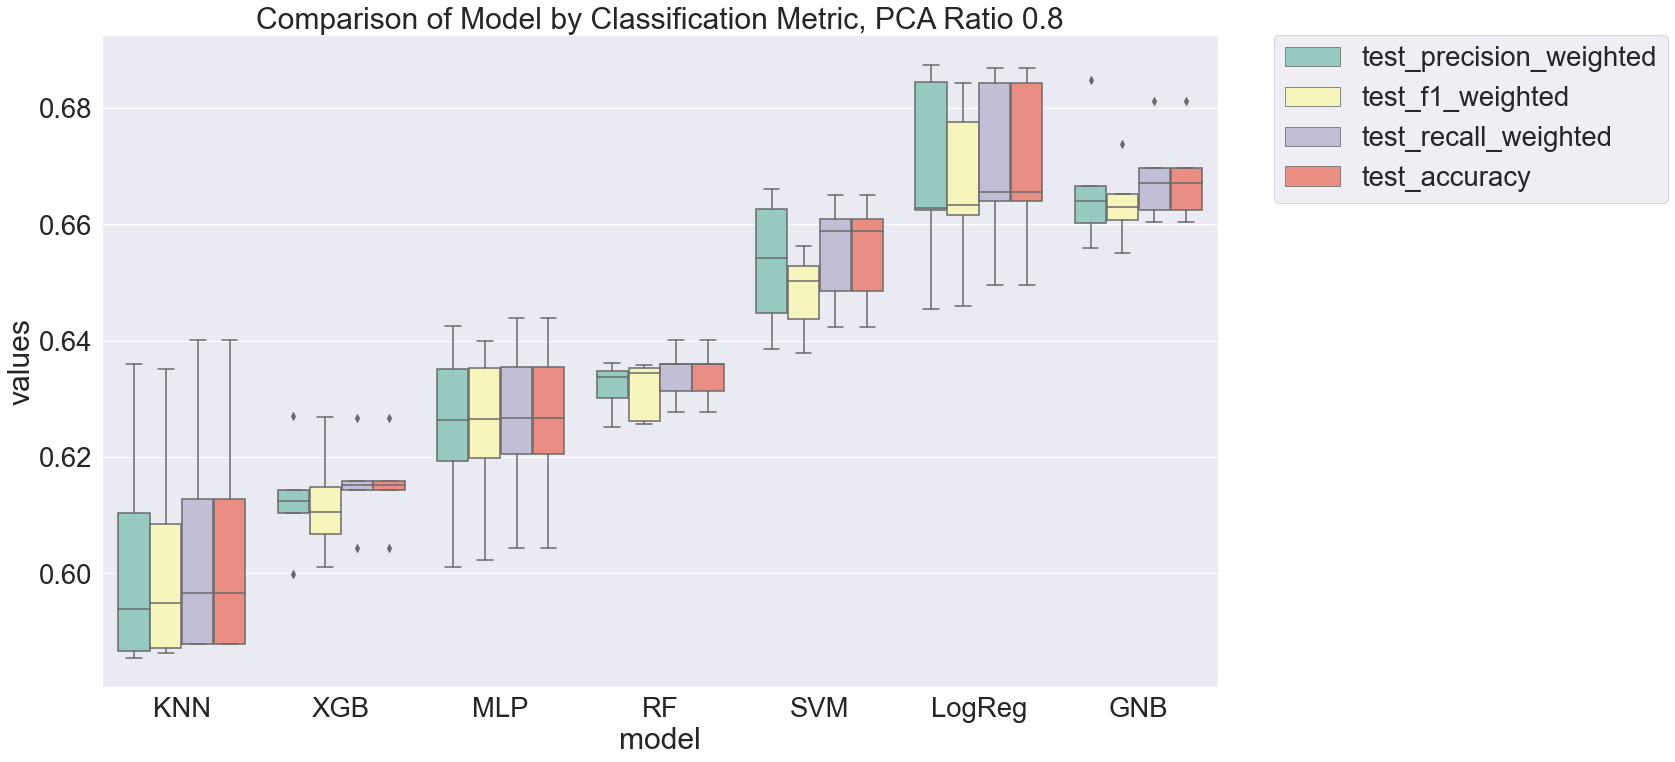

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

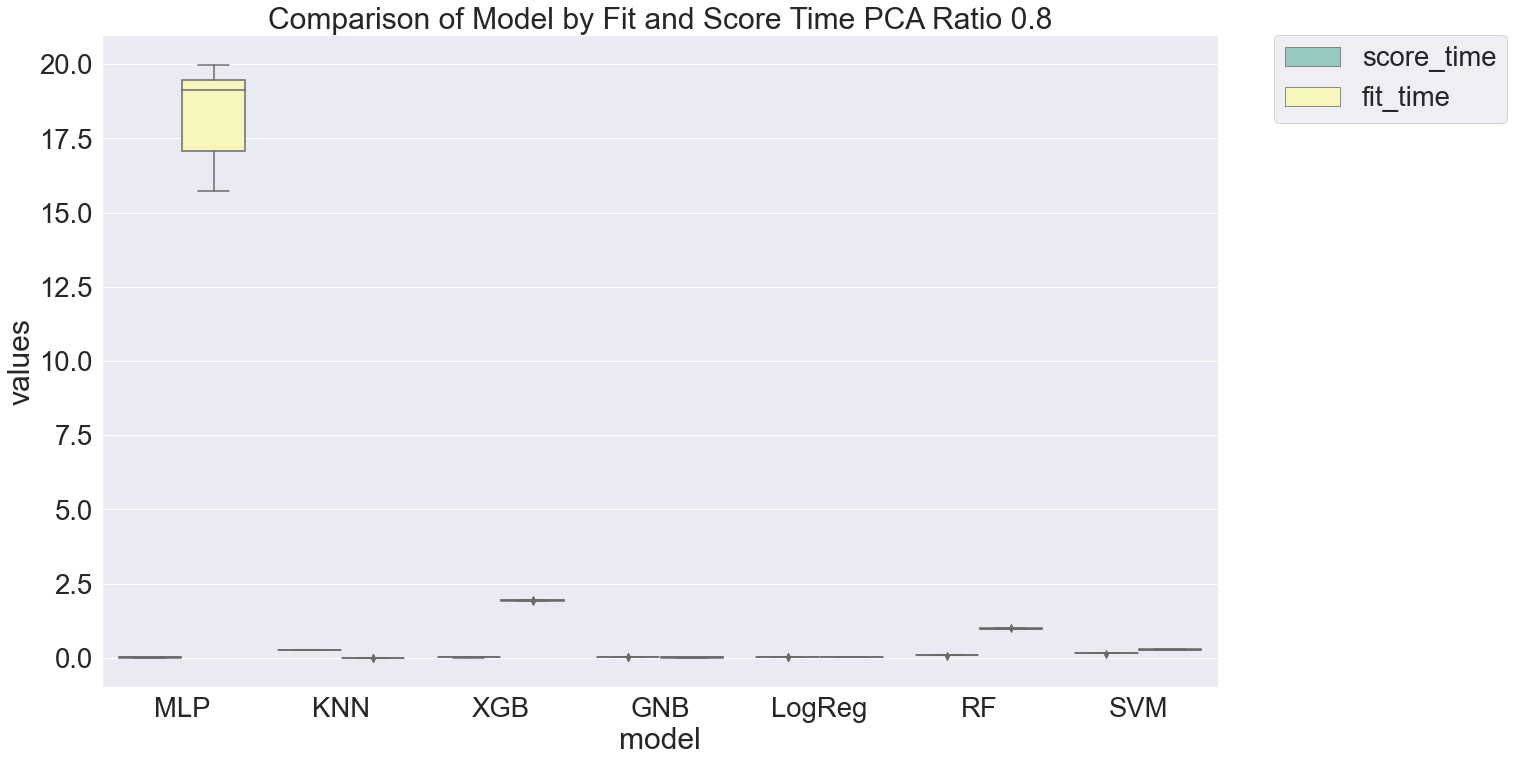

C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function mean at 0x00000262FE5B0E50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

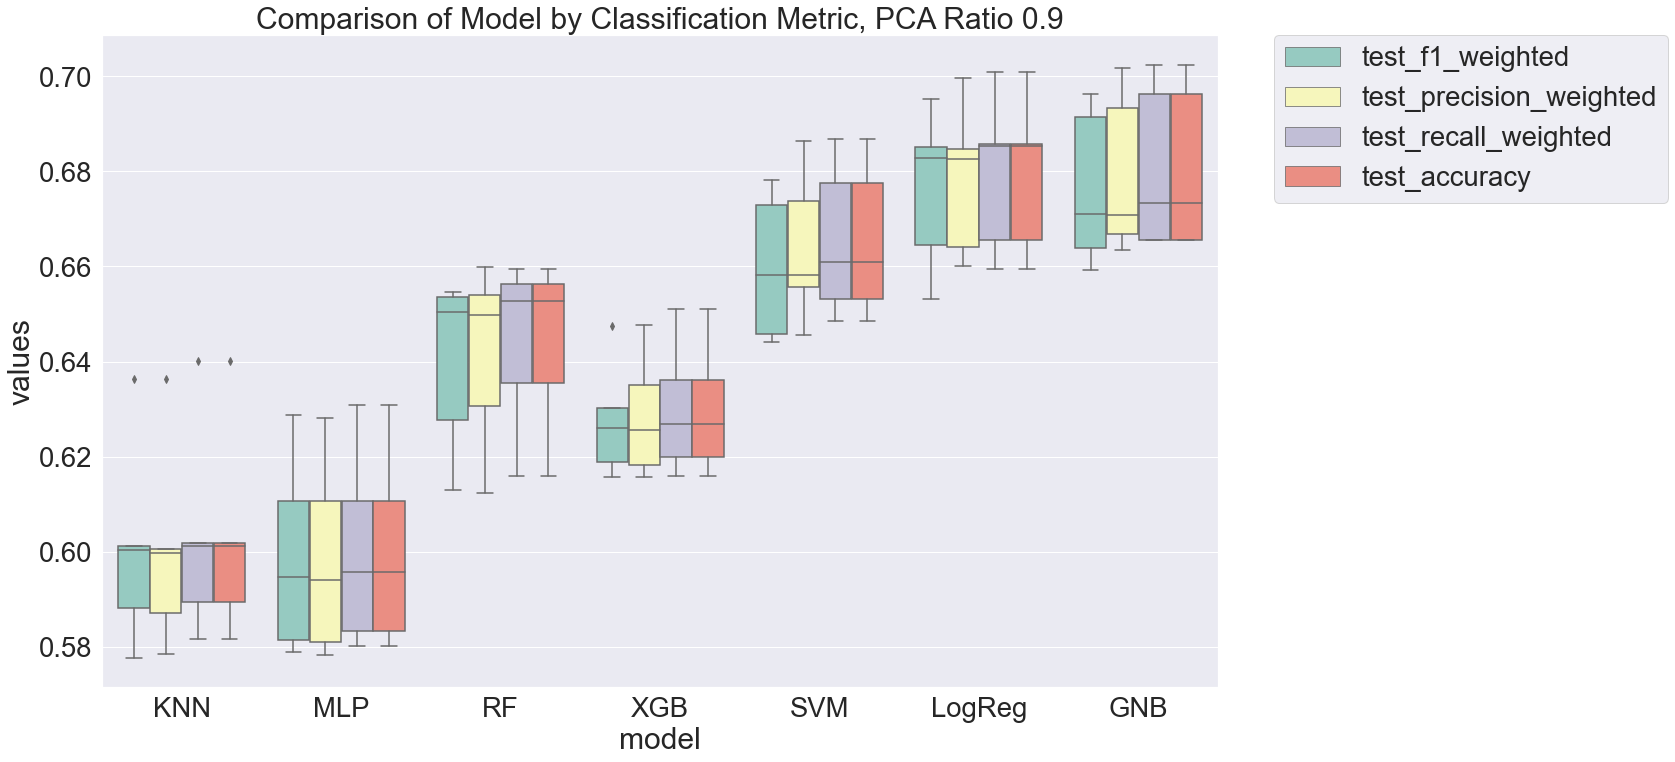

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

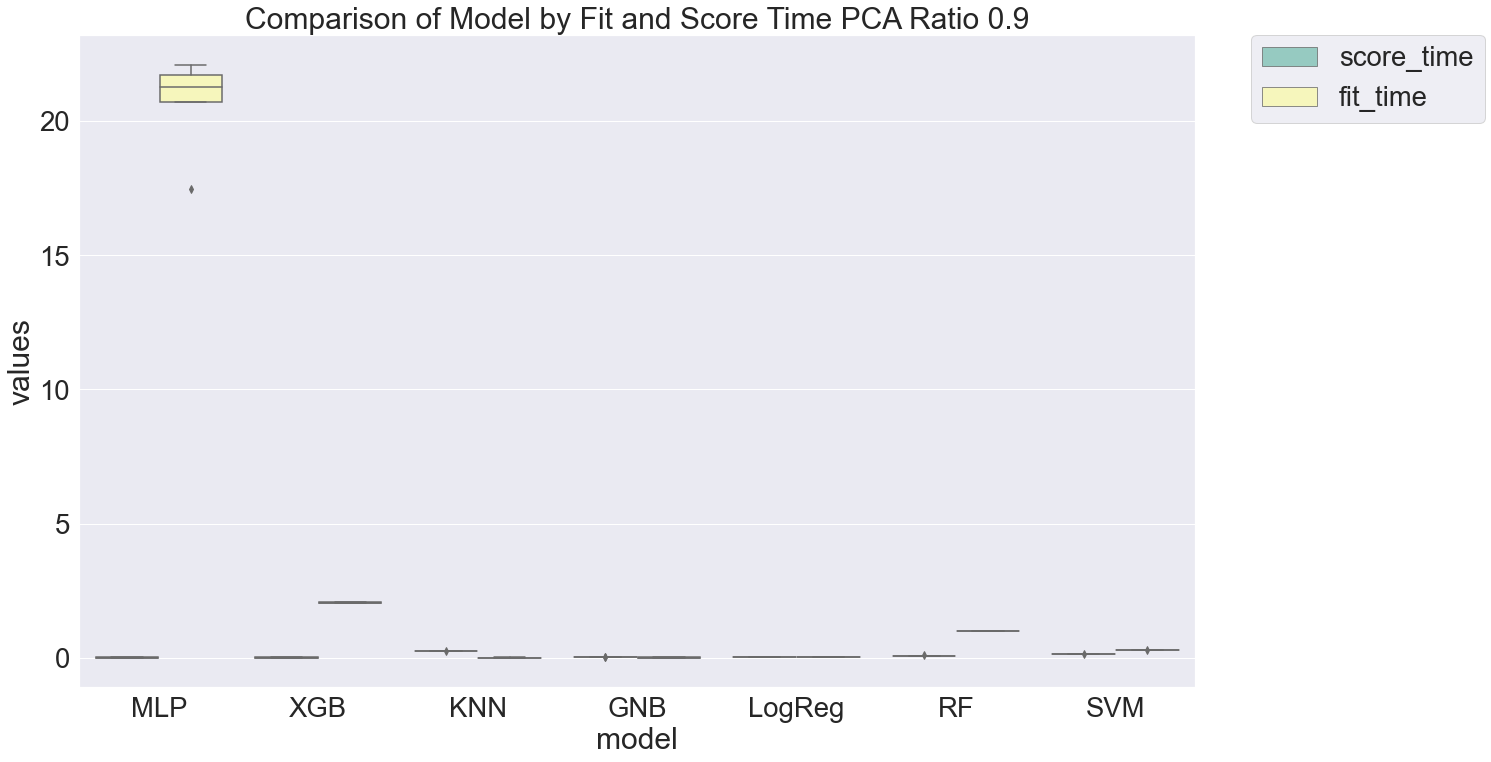

C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function mean at 0x00000262FE5B0E50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

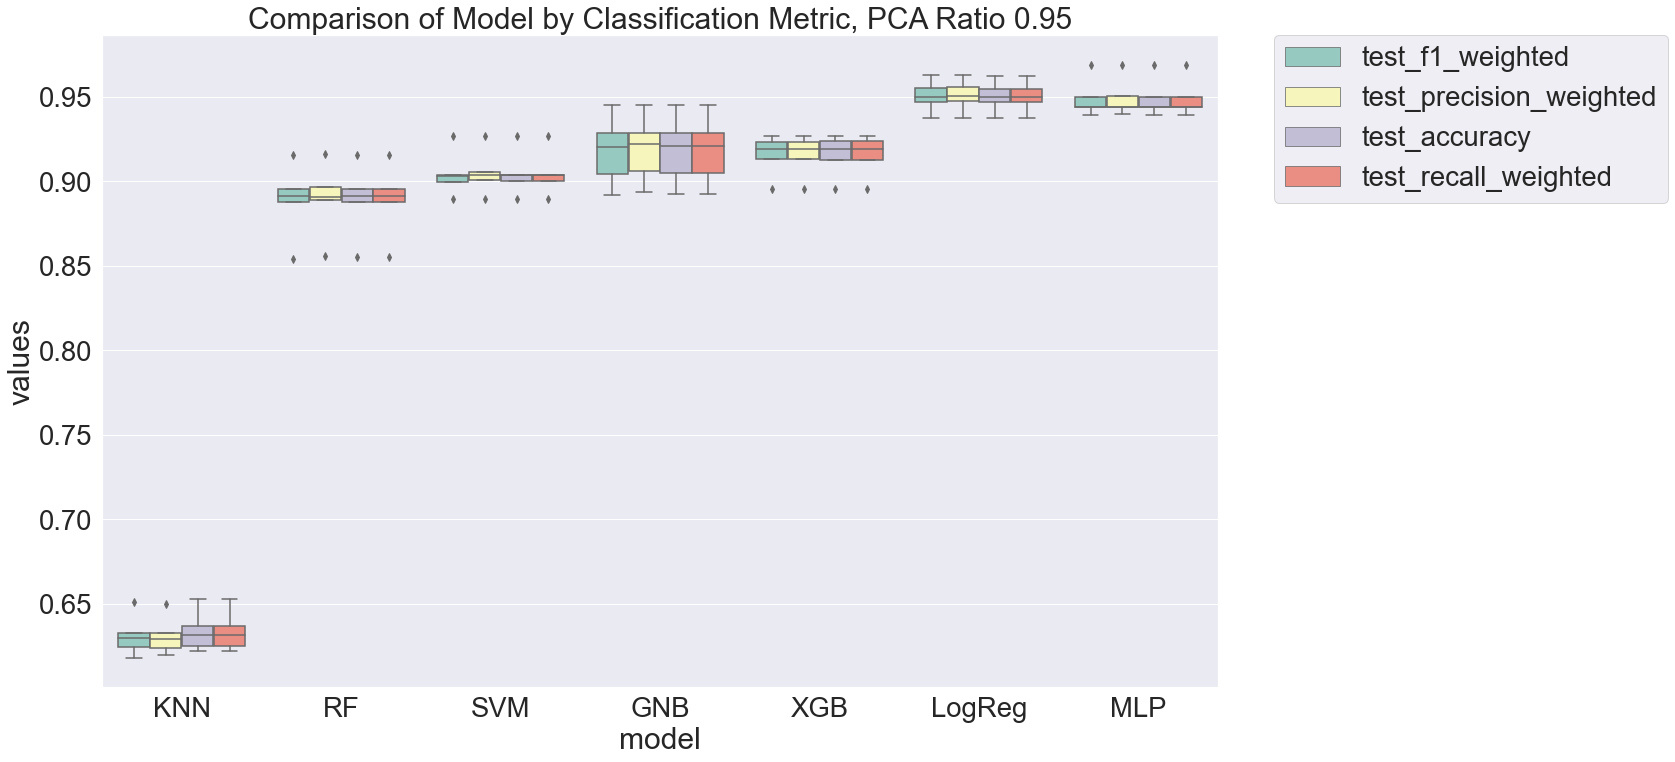

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

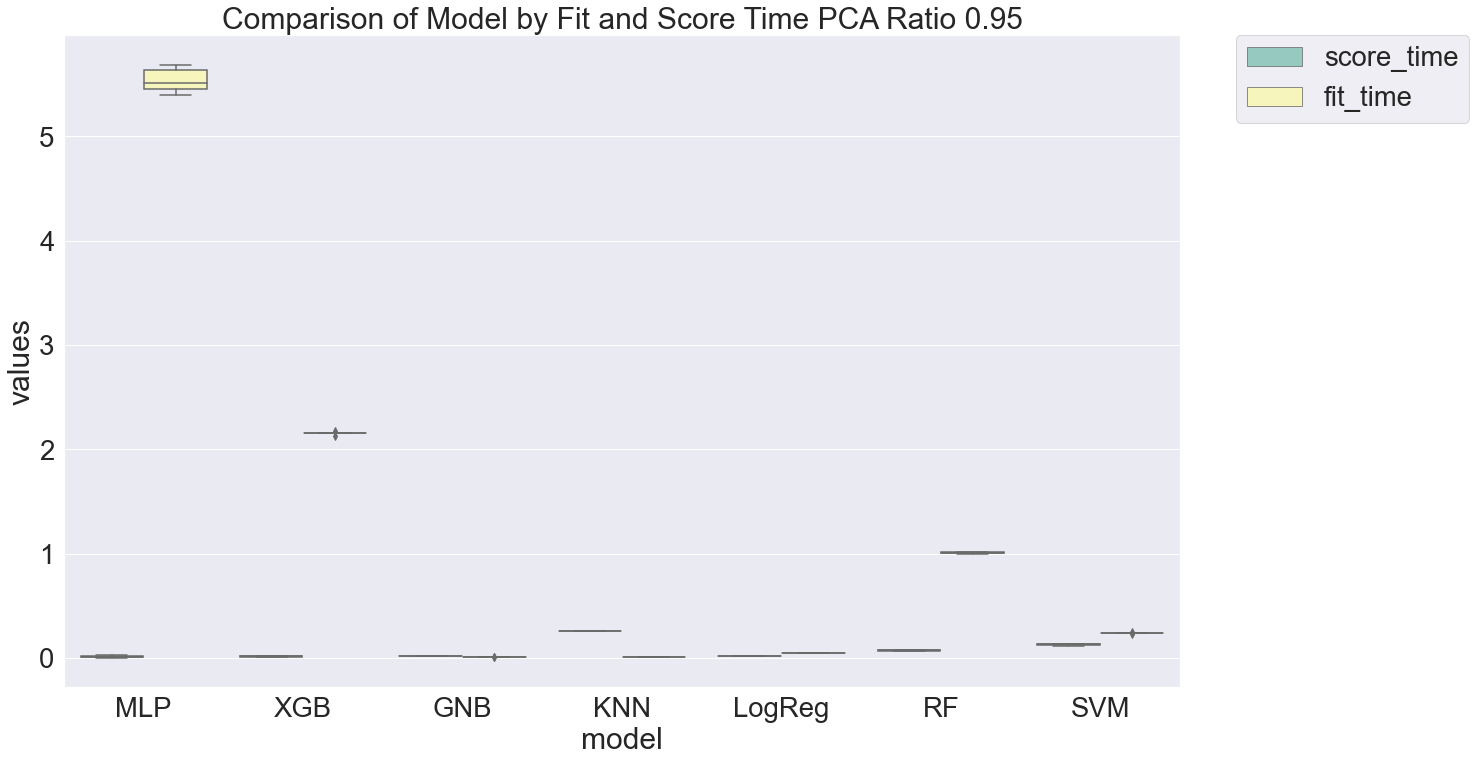

In [40]:
# display results of PCA
for result in pca_results:  
    vdf = result[0][0]
    pca_ratio = result[1]
    method = 'PCA'
    results_long_nofit, results_long_fit = evaluate_models(vdf)
    # n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])
    generate_plots(method, pca_ratio, results_long_nofit, results_long_fit)

C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function mean at 0x00000262FE5B0E50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

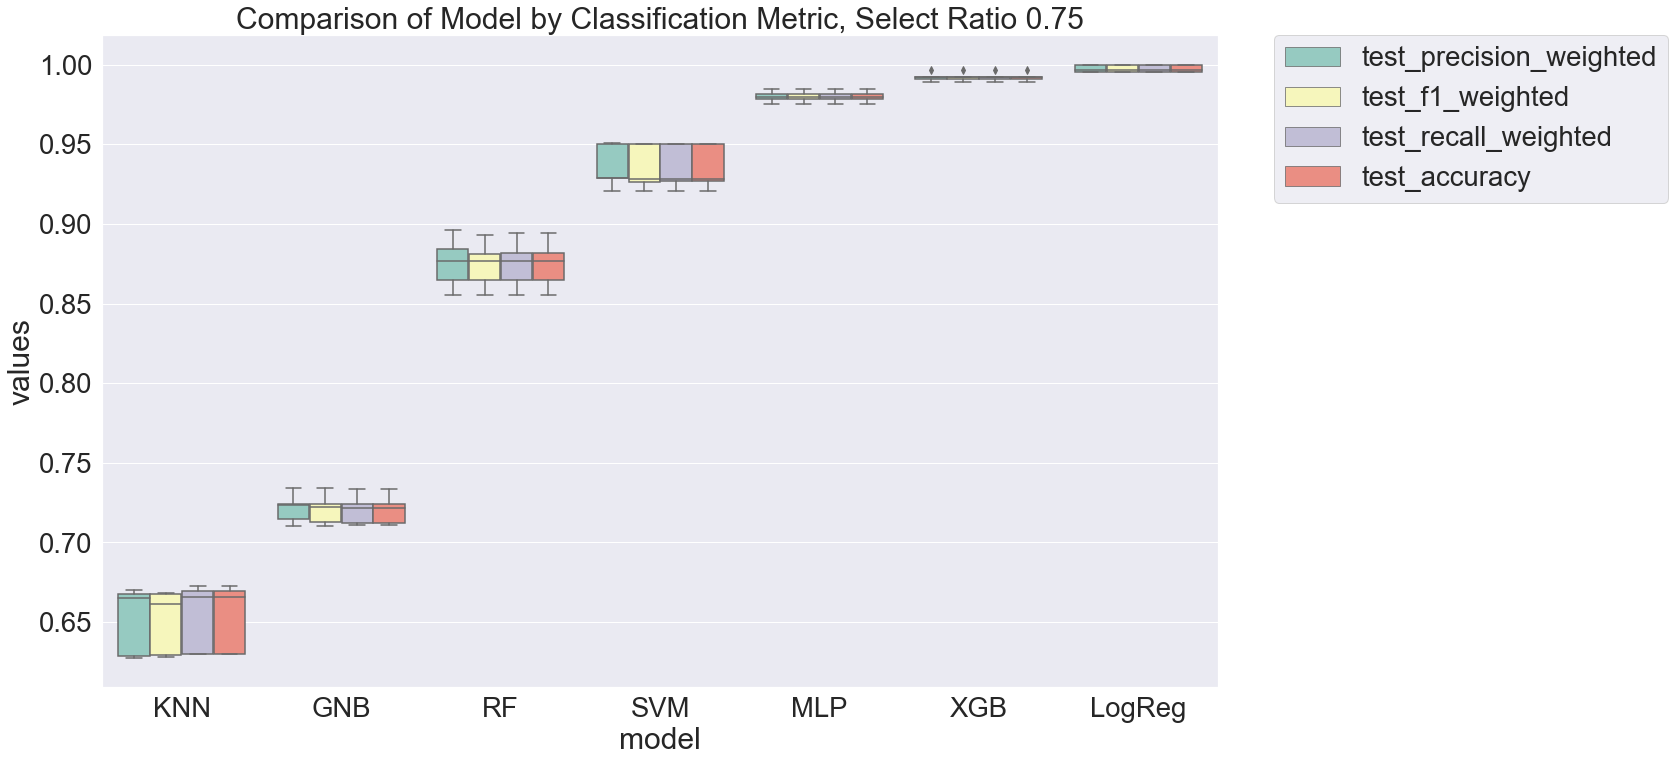

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

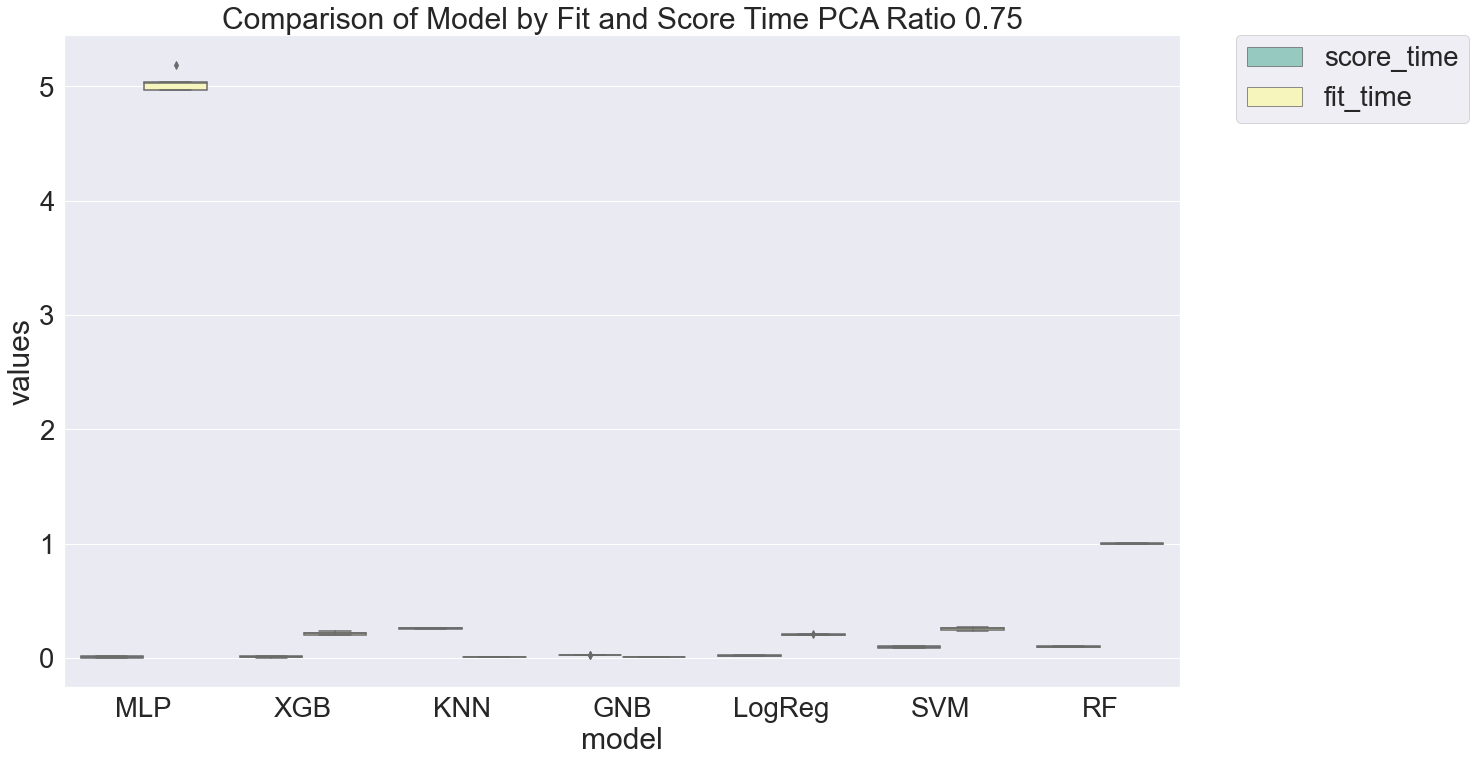

C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function mean at 0x00000262FE5B0E50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

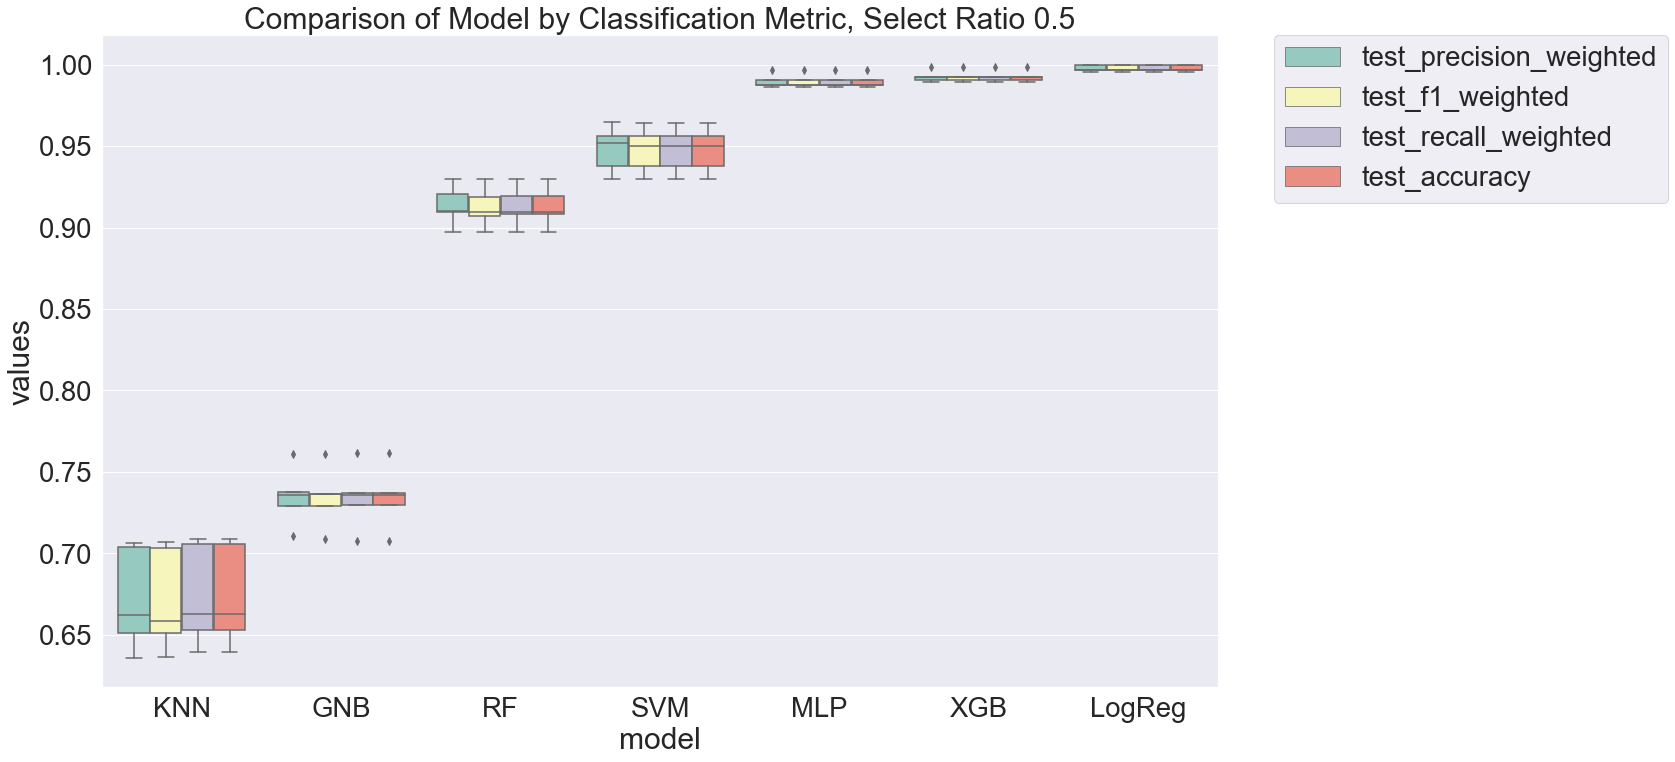

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

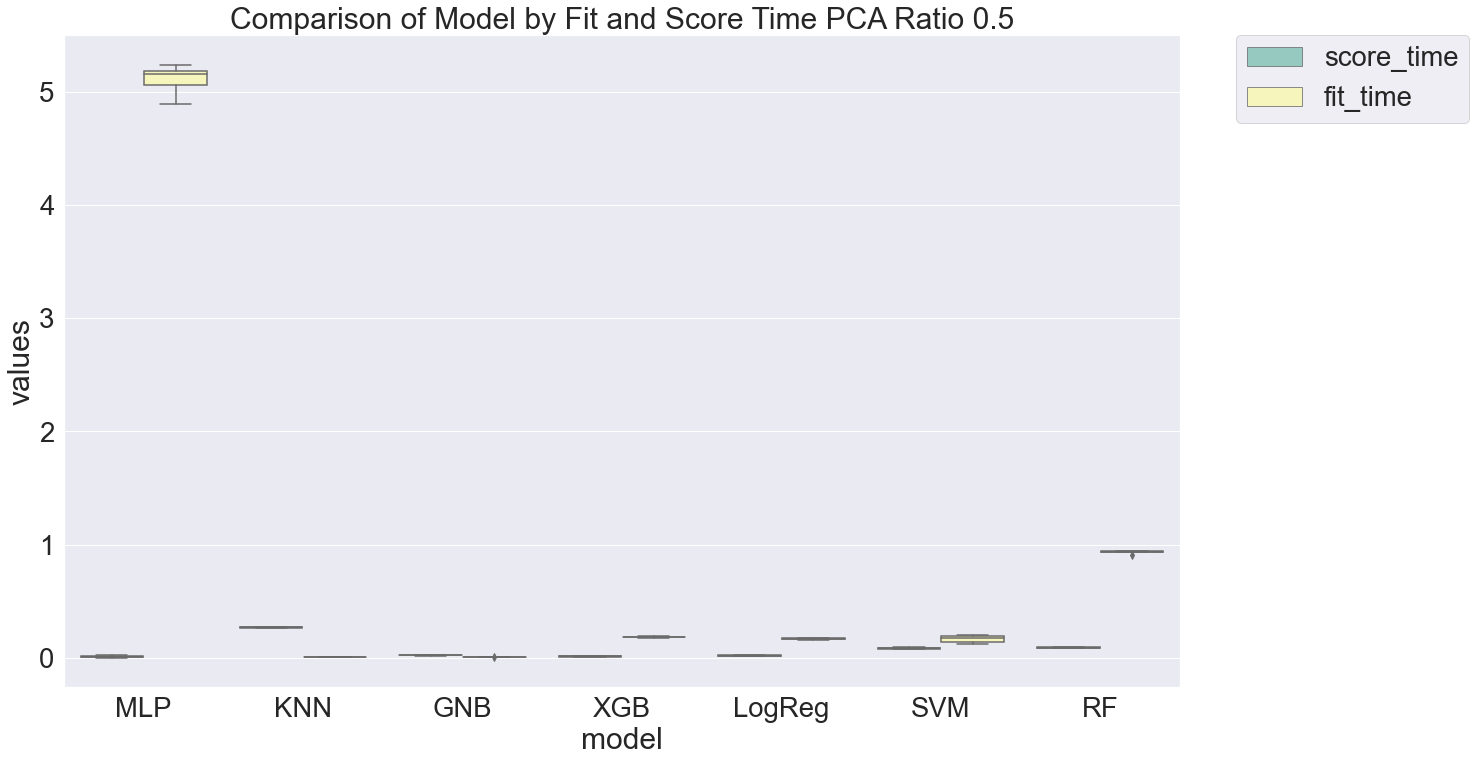

C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function mean at 0x00000262FE5B0E50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_28872\2602992067.py:17: FutureWarning: The provided callable <function std at 0x00000262FE5B3040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

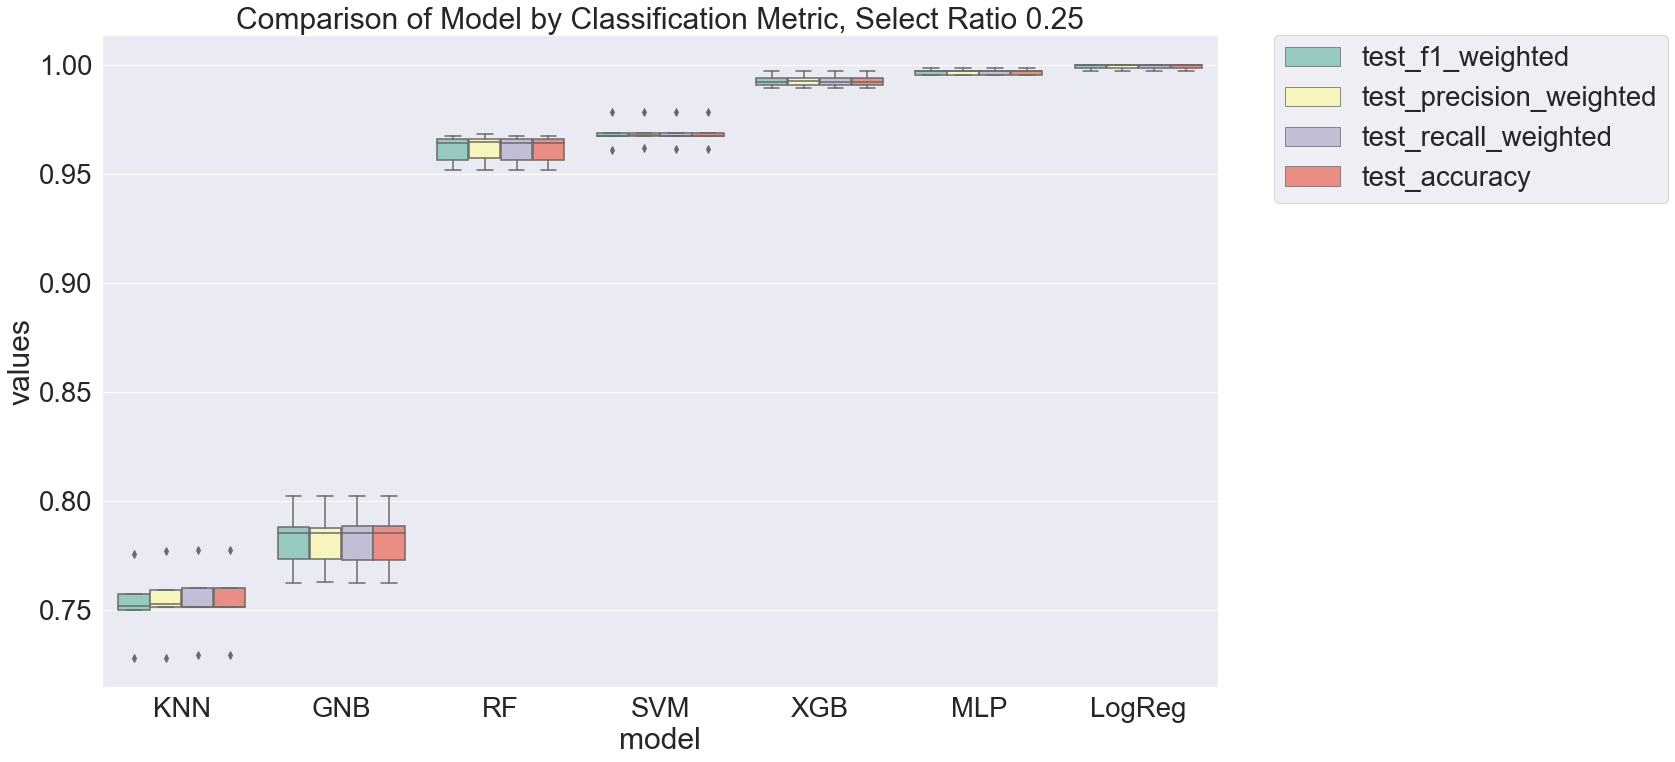

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

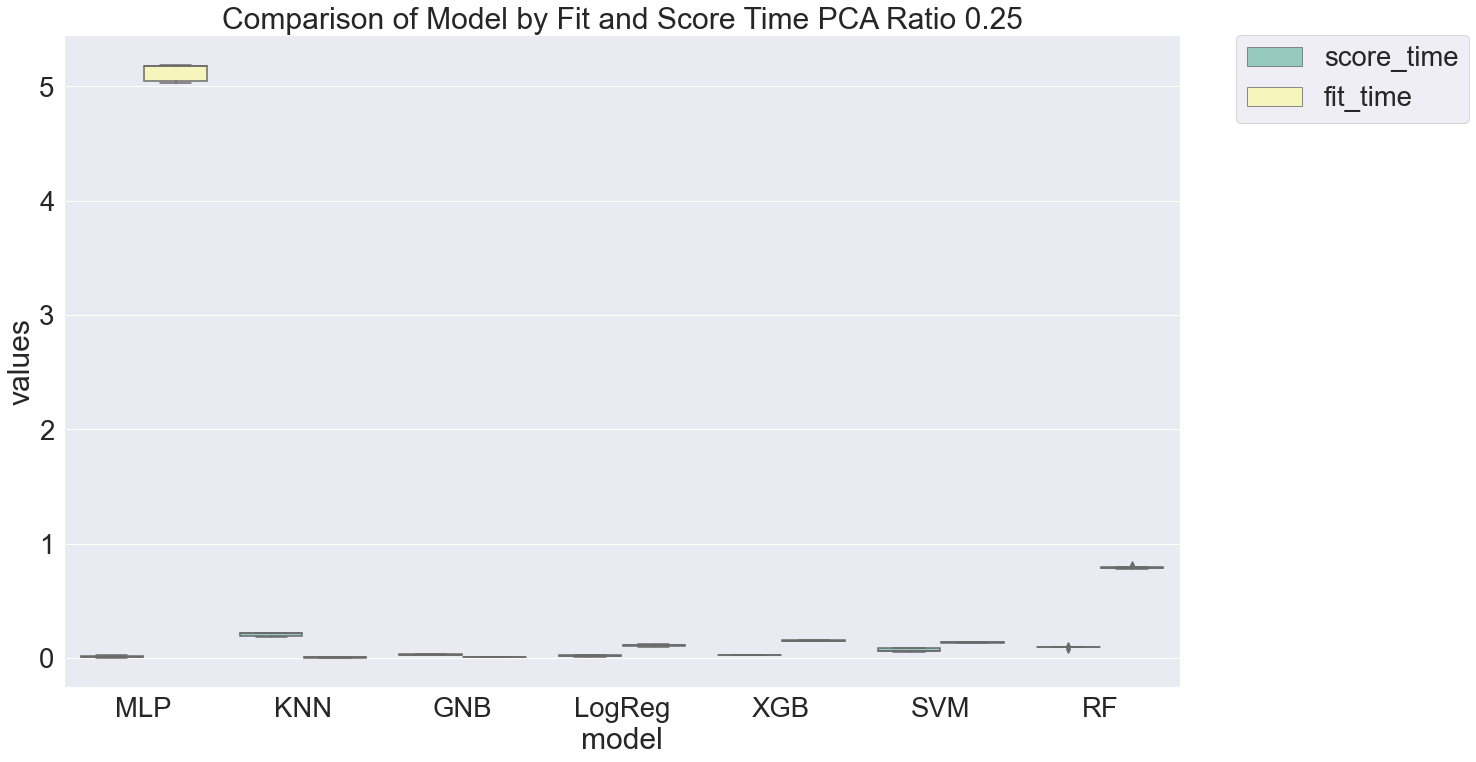

In [41]:
# display results of SelectKBest
for result in select_results:  
    vdf = result[0][0]
    select_ratio = result[1]
    method = 'Select'
    results_long_nofit, results_long_fit = evaluate_models(vdf)
    # n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])
    generate_plots(method, select_ratio, results_long_nofit, results_long_fit)